In [2]:
from cProfile import label
import os
from os import times
from tokenize import cookie_re
from xmlrpc.client import boolean
from numpy.core.shape_base import atleast_2d
from numpy.lib import type_check
from scipy import fftpack
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal
from python_modules import FFT_utility as fu


In [35]:
HPC_OR_LOCAL = "LOCAL"
imputFileName = os.environ["MYWORK"] + \
    "/freqmix/30_100/1/outp_1.csv"
data_raw = fu.loadCsvOutput(imputFileName)
freq_f1 = 100  # GHz
freq_f2 = 30
freq_fsum = freq_f1+freq_f2
freq_fdif = freq_f1 - freq_f2
freq_fgcd = np.gcd(freq_f1, freq_f2)
source_amp_f1 = 1000/freq_f1/20  # A
source_amp_f2 = 1000/freq_f2/20  # A

#freq_index = 0
non_detec_cols = int(3)
Nc_fgcd = 1
Nc_f1 = Nc_fgcd*(freq_f1/freq_fgcd)
Nc_f2 = Nc_fgcd*(freq_f2/freq_fgcd)  # How many cycles to window
v_expt = 5500  # m/s

T_f1 = 1000/freq_f1
"""wave f1's wave cycle [ps]."""
T_f2 = 1000/freq_f2
"""wave f1's wave cycle [ps]."""
T_fgcd = 1000/freq_fgcd

data_raw_cols = data_raw.shape[1]
detecs_num = data_raw_cols - non_detec_cols
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.

time = data_raw[:, 0]
timestep = time[1] - time[0]
x_source = data_raw[:, 1]
x_detecs_array = data_raw[:, 2:2+detecs_num]
x_end = data_raw[:, -1]
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.
a_f1_at_detecs = np.zeros(detecs_num)
a_f2_at_detecs = np.zeros(detecs_num)
a_fsum_at_detecs = np.zeros(detecs_num)
a_fdif_at_detecs = np.zeros(detecs_num)

# not needed for freqmix
a_2f1_at_detecs = np.zeros(detecs_num)
a_3f1_at_detecs = np.zeros(detecs_num)
a_4f1_at_detecs = np.zeros(detecs_num)

beta_SHGs_at_detecs = np.zeros(detecs_num)
beta_SHGs_at_detecs_corrected = np.zeros(detecs_num)
beta_sums_at_detecs = np.zeros(detecs_num)
beta_sums_at_detecs_corrected = np.zeros(detecs_num)
beta_difs_at_detecs = np.zeros(detecs_num)
beta_difs_at_detecs_corrected = np.zeros(detecs_num)
#betaSHGArrayCorrected = np.zeros((len(freqs_f_1), len(detecs)))

#wavelength_f1 = np.zeros(len(freqs_f_1))
#waveVelocityArray = np.zeros((len(freqs_f_1), len(detecs)))

Ns_f1 = T_f1/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f1 = int(Nc_f1*Ns_f1)

Ns_f2 = T_f2/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f2 = int(Nc_f2*Ns_f2)

Ns_fgcd = T_fgcd/timestep
N_fgcd = int(Nc_fgcd*Ns_fgcd)

if(N_f1 != N_f2 or N_f2 != N_fgcd or N_fgcd != N_f1):
    print("REVIEW YOUR INPUT")

u_detecs_array = x_detecs_array - x_detecs_array[0]

delta_x_source_detec0 = x_detecs_array[0, 0] - x_source[0]
delta_x_detecs = x_detecs_array[0, 1] - x_detecs_array[0, 0]
delta_t_detecs = delta_x_detecs/10*(10**3)/5500  # ps


# フーリエ変換
for i in range(detecs_num):
    # ゼロクロス法の音速測定
    # Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
    # この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

    zerocross_timestep, arrival_timestep, wave_velocity = fu.wave_arrival_zerocross(
        u_detec, delta_x_source_to_thisdetec, v_expt, timestep, T_fgcd)

    window_start_timestep = zerocross_timestep - int(2*T_f2/timestep)

    wavelength_f1 = wave_velocity * T_f1 * (10**(-12))
    wavelength_f2 = wave_velocity * T_f2 * (10**(-12))

    # ここまで音速測定

    trimmedWave = fu.trimAndOffset(u_detec, window_start_timestep, N_fgcd)
    trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

    windowedWave = fu.window(trimmedWave, "hann")
    paddedWave = fu.zeroPadding(windowedWave)
    paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

    ##SUPER IMPORTANT##
    waveToTransform = trimmedWave
    ##CHOU DAIJI##

    """if (i==detecs_num-2):
        plt.plot(time, u_detec)
        plt.axvline(x=window_start_timestep*timestep)
        plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
        plt.show()"""

    # FFT. transformedArray: [0]=power, [1]=freq
    # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
    #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
    ffted_data = fu.FFTonly(waveToTransform, timestep)
    #FFTedData=FFTonly(window(trimmedWave, "hann"))
    abs_ffted_data = np.abs(ffted_data)

    index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
    A_fsum = abs_ffted_data[0][index_fsum]
    a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
    a_fsum_at_detecs[i] = a_fsum

    index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
    A_fdif = abs_ffted_data[0][index_fdif]
    a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
    a_fdif_at_detecs[i] = a_fdif

    index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][index_f1]
    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
    A_f2 = abs_ffted_data[0][index_f2]
    a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
    a_f2_at_detecs[i] = a_f2

    beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                                 freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, v_expt)
    beta_mix_corrected = fu.getBetaFreqMix(
        a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, v_expt)

    beta_sum = beta_mix[0]
    beta_sum_corrected = beta_mix_corrected[0]
    beta_sums_at_detecs[i] = beta_sum
    beta_sums_at_detecs_corrected[i] = beta_sum_corrected

    beta_dif = beta_mix[1]
    beta_dif_corrected = beta_mix_corrected[1]
    beta_difs_at_detecs[i] = beta_dif
    beta_difs_at_detecs_corrected[i] = beta_dif_corrected

    # higher harmonics amplitude[arb]
    harmonicsIndex = fu.getIndexUpToSixthHarmonic(
        abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
    A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
    A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
    A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
    A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
    A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
    a_2f1_at_detecs[i] = a_2f1

    a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
    a_3f1_at_detecs[i] = a_3f1

    a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
    a_4f1_at_detecs[i] = a_4f1

    a_f1_source = source_amp_f1*10**-10
    a_f2_source = source_amp_f2*10**-10

    beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                             delta_x_source_to_thisdetec*(10**-10))
    beta_shg_corrected = fu.getBetaSHG(
        a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
    """with open("betaSHG.txt", "w") as f:
        f.write(str(betaSHG))
    """
    beta_SHGs_at_detecs[i] = beta_shg
    beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

# drawings
# if detec_index-detec_num_min == 10 and freq == 200:
if False:
    # if True:
    # if HPC_OR_LOCAL == "LOCAL" and detecNum-detecMin == 10 :
    fig = plt.figure()
    print("x_detec1")
    y = u_detec
    time_red = time[window_start_timestep:window_start_timestep+N]
    y_red = y[window_start_timestep:window_start_timestep+N]
    time1 = time[:window_start_timestep]
    y1 = y[:window_start_timestep]
    time2 = time[window_start_timestep+N:]
    y2 = y[window_start_timestep+N:]
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.plot(time, y)
    plt.plot(time_red, y_red, color="red")
    plt.axvline(x=arrival_timestep*timestep,
                color="green", linestyle="--")
    #plt.axvline(x=windowStartTimeStep*timeStep, color="red")
    #plt.axvline(x=(windowStartTimeStep+N)*timeStep, color="red")
    plt.show()

    print("timeStep Δt is:")
    print(timestep)

    print("trimmed and offseted form of superimposed wave")
    plt.title("Trimmed Wave for 20ps")
    plt.plot(trimmedTime, trimmedWave)
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("Windowed Wave")
    plt.plot(trimmedTime, windowedWave)
    plt.title("Windowed Wave")
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("padded wave")
    plt.plot(paddedWave)
    plt.show()

    print()
    print("timeStep Δt is:")
    print(timestep)

    print("wave velocity v[m/s] is:")
    print(wave_velocity)

    print("wave length λ1 is:")
    print(waveLength1)

    fig, ax = plt.subplots()
    ax.set_yscale("log")
    #ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
    ax.plot(abs_ffted_data[1, 0:getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1, inputFreq2))*4],
            abs_ffted_data[0, 0:getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1, inputFreq2))*4], marker="o", linestyle="--")
    ax.set_xlabel("Freqency [Hz]")
    ax.set_ylabel("Amplitude [arb.]")
    ax.grid()
    plt.title("Frequency spectrum")
    plt.show()

    print(a_f1, af2, asum, adif)

    print("beta(SHG):")
    print(beta_shg)
    betaSHGArray[freq_index, detec_index] = beta_shg
    print("beta(FreqMix): f1-f2, f1+f2, ave ")
    print(betaFreqMix)

    x_bar = np.array([inputFreq2, freq_f1-inputFreq2,
                      freq_f1, freq_f1+inputFreq2, inputFreq2*2])
    y_bar = np.array([Af2, Afdif, Af1, Afsum, A_2f1])
    x_bar = x_bar / 10**11
    plt.xlabel("100GHz")
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()

    x_bar = np.array(["$f_1$", "$2f_1$", "3$f_1$",
                      "4$f_1$", "5$f_1$", "6$f_1$"])
    y_bar = np.array([A_f1, A_2f1, A_3f1, A_4f1, A_5f1, A_6f1])
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()
# print(af1s[freq_index])
# print(a2f1s[freq_index])
#np.savetxt(str(freq)+"GHzDamp.txt", af1s[freq_index])


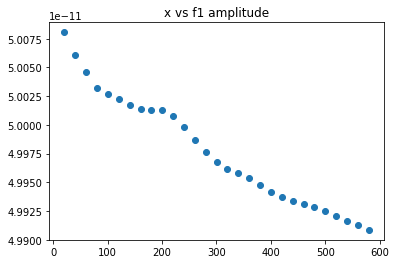

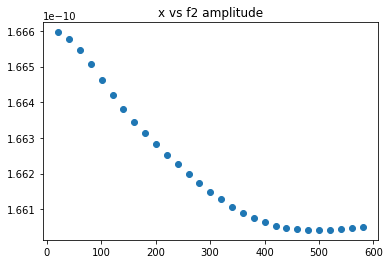

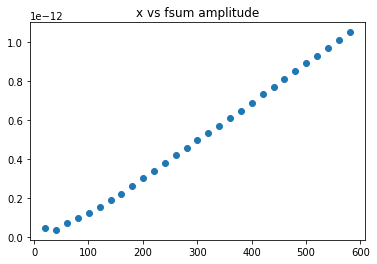

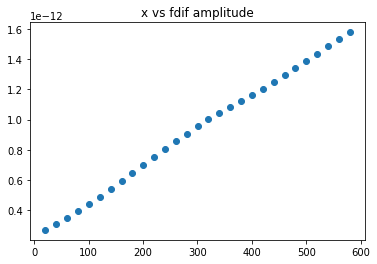

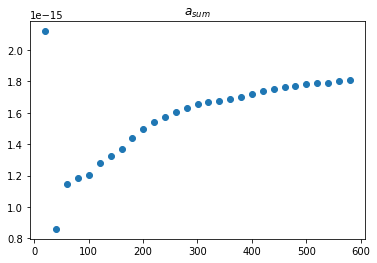

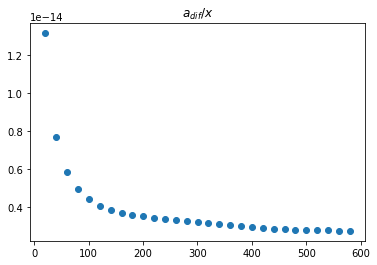

In [29]:
plt.plot(x_detecs_array[0, :], a_f1_at_detecs, marker="o", linestyle="none")
plt.title("x vs f1 amplitude")
plt.show()

plt.plot(x_detecs_array[0, :], a_f2_at_detecs, marker="o", linestyle="none")
plt.title("x vs f2 amplitude")
plt.show()

plt.plot(x_detecs_array[0, :], a_fsum_at_detecs, marker="o", linestyle="none")
plt.title("x vs fsum amplitude")
plt.show()

plt.plot(x_detecs_array[0, :], a_fdif_at_detecs, marker="o", linestyle="none")
plt.title("x vs fdif amplitude")
plt.show()



fig, ax = plt.subplots()
ax.set_title("$a_{sum}}/x$")
ax.plot(x_detecs_array[0, :], a_fsum_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none")
plt.show()
fig, ax = plt.subplots()
ax.set_title("$a_{dif}/x$")
ax.plot(x_detecs_array[0, :], a_fdif_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none")
plt.show()




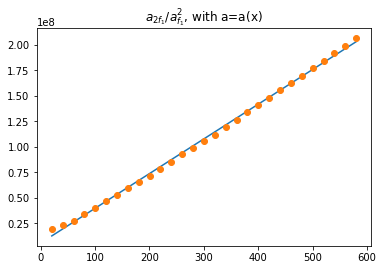

340359.6613374918
2.043156647363292


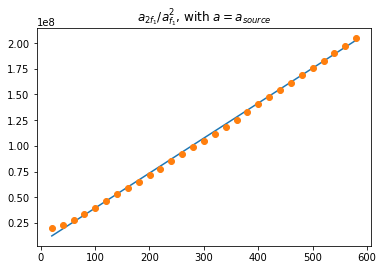

337441.04273354076
2.025636371963006


In [ ]:
# slope method
res1 = np.polyfit(
    x_detecs_array[0, :], a_2f1_at_detecs/a_f1_at_detecs/a_f1_at_detecs, 1)
linear = np.poly1d(res1)(x_detecs_array[0, :])
plt.plot(x_detecs_array[0, :], linear)
plt.plot(x_detecs_array[0, :], a_2f1_at_detecs /
         a_f1_at_detecs/a_f1_at_detecs, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with a=a(x)")
plt.show()
print(res1[0])
print(res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_corr = res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2

res2 = np.polyfit(x_detecs_array[0, :],
                  a_2f1_at_detecs/a_f1_source/a_f1_source, 1)
linear = np.poly1d(res1)(x_detecs_array[0, :])
plt.plot(x_detecs_array[0, :], linear)
plt.plot(x_detecs_array[0, :], a_2f1_at_detecs /
         a_f1_source/a_f1_source, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with $a=a_{source}$")
plt.show()
print(res2[0])
print(res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_source = res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2


3.1327976773874053
3.116409730328814
2.805543564264873
2.820296791016252
2.5077959046450986
2.494677398200932


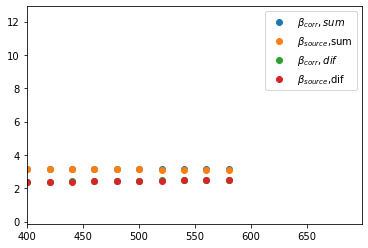

In [37]:
print(beta_sums_at_detecs_corrected[-1])
print(beta_sums_at_detecs[-1])
print((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2)
print((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2)

print(beta_difs_at_detecs_corrected[-1])
print(beta_difs_at_detecs[-1])

fig, ax = plt.subplots()

ax.plot(x_detecs_array[0, :], beta_sums_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},sum$")
ax.plot(x_detecs_array[0, :], beta_sums_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,sum")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},dif$")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,dif")
"""ax.axhline(y=beta_slope_corr, linestyle="--",
           color="red", label=r"$\beta _{slope,corr}$")"""
"""ax.axhline(y=beta_slope_source, linestyle="--",
           color="green", label=r"$\beta _{slope,source}$")"""
ax.set_xlim([400,699])
ax.legend()
plt.show()


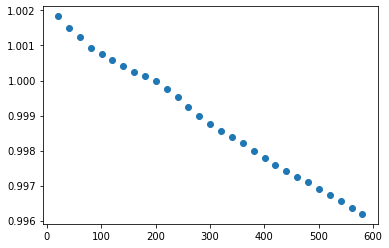

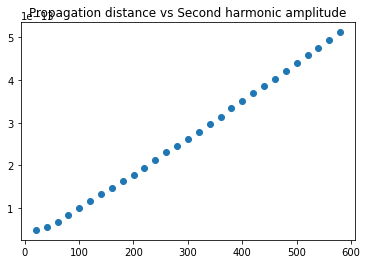

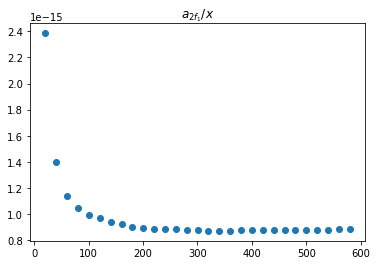

In [4]:
plt.plot(x_detecs_array[0, :], a_f1_at_detecs /
         a_f1_source, marker="o", linestyle="none")
plt.show()

plt.plot(x_detecs_array[0, :], a_2f1_at_detecs, marker="o", linestyle="none")
plt.title("Propagation distance vs Second harmonic amplitude")
plt.show()

fig, ax = plt.subplots()
ax.set_title("$a_{2f_1}/x$")
ax.plot(x_detecs_array[0, :], a_2f1_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none")
plt.show()


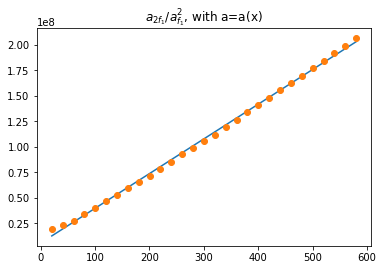

340359.6613374918
2.043156647363292


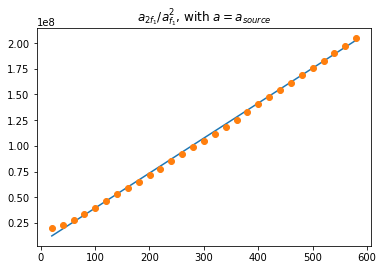

337441.04273354076
2.025636371963006


In [9]:
# slope method
res1 = np.polyfit(
    x_detecs_array[0, :], a_2f1_at_detecs/a_f1_at_detecs/a_f1_at_detecs, 1)
linear = np.poly1d(res1)(x_detecs_array[0, :])
plt.plot(x_detecs_array[0, :], linear)
plt.plot(x_detecs_array[0, :], a_2f1_at_detecs /
         a_f1_at_detecs/a_f1_at_detecs, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with a=a(x)")
plt.show()
print(res1[0])
print(res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_corr = res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2

res2 = np.polyfit(x_detecs_array[0, :],
                  a_2f1_at_detecs/a_f1_source/a_f1_source, 1)
linear = np.poly1d(res1)(x_detecs_array[0, :])
plt.plot(x_detecs_array[0, :], linear)
plt.plot(x_detecs_array[0, :], a_2f1_at_detecs /
         a_f1_source/a_f1_source, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with $a=a_{source}$")
plt.show()
print(res2[0])
print(res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_source = res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2


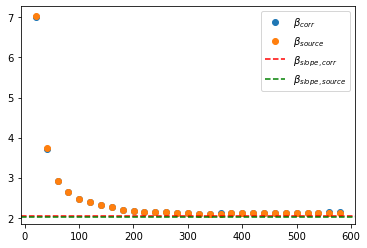

In [10]:
fig, ax = plt.subplots()

ax.plot(x_detecs_array[0, :], beta_SHGs_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr}$")
ax.plot(x_detecs_array[0, :], beta_SHGs_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$")
ax.axhline(y=beta_slope_corr, linestyle="--",
           color="red", label=r"$\beta _{slope,corr}$")
ax.axhline(y=beta_slope_source, linestyle="--",
           color="green", label=r"$\beta _{slope,source}$")
ax.legend()
plt.show()


In [11]:
print(beta_slope_source)
print(beta_slope_corr)
print(beta_SHGs_at_detecs[-1])
print(beta_SHGs_at_detecs_corrected[-1])


2.025636371963006
2.043156647363292
2.1201488690884758
2.136392662221278
